# **Wine Type Classification**

**Intuition:** We will use Keras to classify the type of Wines into Red or White.

**Dataset Source:**
1) Red Wine- *http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv*
2) White Wine- *http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv*

**Importing the libraries**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import csv
from requests import Session
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

Using TensorFlow backend.


**Importing the Datasets**

In [0]:
red_wine = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep =';')
white_wine = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep =';')

**Description of the Datasets**

In [3]:
red_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [4]:
white_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


**Checking for Missing Data**

In [5]:
print(red_wine.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [6]:
print(red_wine.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


**Plotting the Distribution of Alcohol**

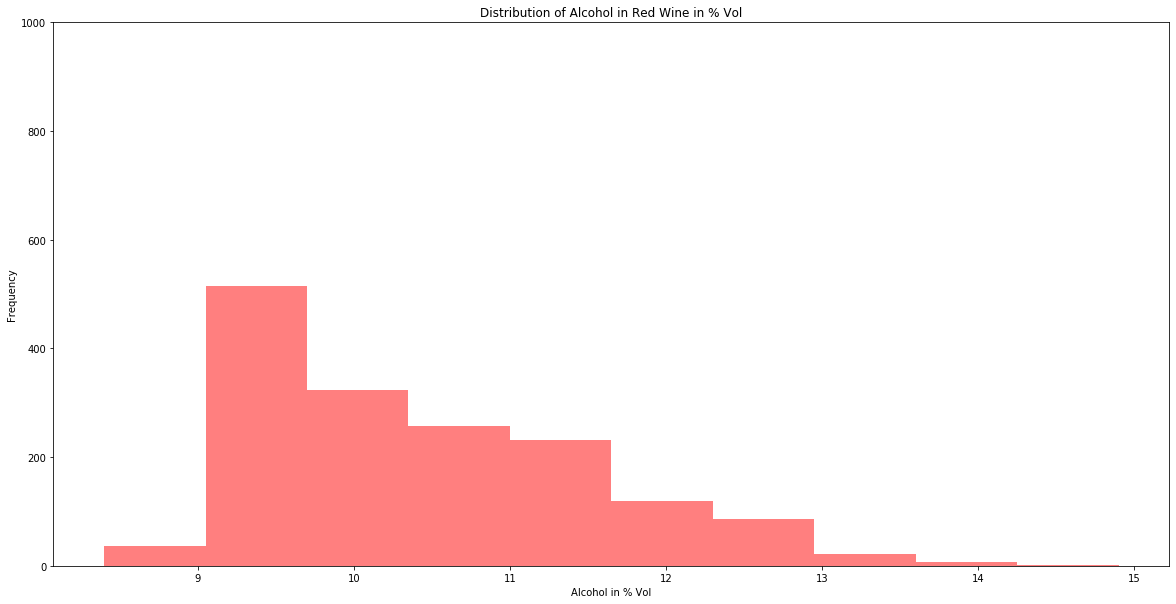

In [7]:
plt.figure(figsize = (20, 10))
plt.hist(red_wine.alcohol, facecolor = 'red', 
              alpha = 0.5, label = "Red Wine")
plt.ylim([0, 1000])
plt.xlabel("Alcohol in % Vol")
plt.ylabel("Frequency")
plt.title("Distribution of Alcohol in Red Wine in % Vol")
plt.show()

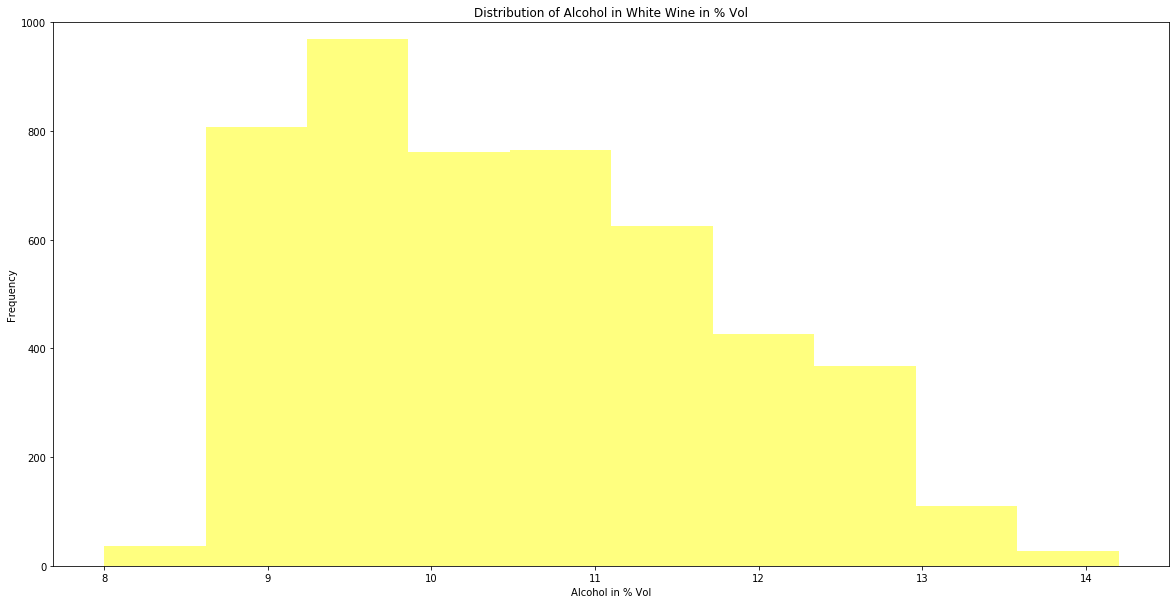

In [8]:
plt.figure(figsize = (20, 10))
plt.hist(white_wine.alcohol, facecolor = 'yellow', 
              alpha = 0.5, label = "White Wine")
plt.ylim([0, 1000])
plt.xlabel("Alcohol in % Vol")
plt.ylabel("Frequency")
plt.title("Distribution of Alcohol in White Wine in % Vol")
plt.show()

**Add `type` column to `red` with price '1' & to `white` with price '0'**


In [0]:
red_wine['type'] = 1
white_wine['type'] = 0

**Joining the Datasets**

In [10]:
wines = red_wine.append(white_wine, ignore_index = True)
wines.count()

fixed acidity           6497
volatile acidity        6497
citric acid             6497
residual sugar          6497
chlorides               6497
free sulfur dioxide     6497
total sulfur dioxide    6497
density                 6497
pH                      6497
sulphates               6497
alcohol                 6497
quality                 6497
type                    6497
dtype: int64

**Splitting Dependant & Independant Variables**

In [0]:
X = wines.ix[:, 0:11]
y = np.ravel(wines.type)

**Splitting Dataset into Training & Test Sets**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

**Feature Scaling**

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [14]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10
0,-1.717476,1.628406,-1.371392,-0.879497,-1.342016,1.916457,-0.280421,-2.489573,0.261827,-1.080583,2.543580
1,-0.319330,-0.364311,0.559013,3.558693,-0.231910,0.970171,0.899205,2.156718,-1.797213,-0.213424,-1.506767
2,-1.173753,-0.726623,-0.819848,2.272261,-0.345767,0.580524,-0.051538,1.343617,0.012246,-0.480242,-1.338003
3,0.379742,1.628406,-0.957734,-0.643651,0.764340,-1.367712,-1.688930,0.551015,0.449012,0.453622,-0.241034
4,0.612767,0.481084,0.007469,-0.622211,0.678947,-0.254434,0.106919,1.135218,0.012246,3.588737,-0.662945


In [15]:
pd.DataFrame(X_test).head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.707704,-0.968164,-0.544076,-0.429246,-0.089588,-0.588418,0.054100,-0.326998,-0.674100,-0.080015,-1.084856
1,-0.319330,-1.209705,-0.957734,-0.858056,-0.260374,-0.031779,-0.456485,-1.041023,0.324222,0.053394,0.602789
2,0.069043,-0.726623,1.248443,1.779129,-0.203445,1.415482,1.286545,1.610096,0.137036,0.853849,-1.253620
3,0.302068,1.990718,-1.233506,-0.836616,0.508161,-0.310098,0.916811,-0.337247,-1.048471,-0.146719,-1.000474
4,0.069043,-0.787008,-0.199360,-0.815175,-0.630409,-0.087443,0.036493,-1.020525,0.511407,-0.213424,0.434024


**Initializing the ANN**

In [16]:
classifier = Sequential()

**Adding the Input Layer and the First Hidden Layer**

In [17]:
classifier.add(Dense(output_dim = 20, init  ='uniform', activation = 'relu', input_shape = (11,)))

**Adding the 2nd Input Layer**

In [0]:
classifier.add(Dense(output_dim = 10, init  ='uniform', activation = 'relu'))

**Adding the Output Layer**

In [0]:
classifier.add(Dense(output_dim = 1, init  ='uniform', activation = 'sigmoid'))

**Compiling the ANN**

In [20]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**Fitting the ANN to the Training Set**

In [21]:
classifier.fit(X_train, y_train, batch_size = 10, epochs = 50)




Epoch 1/50





5197/5197 [==============================] - 1s 186us/step - loss: 0.2257 - acc: 0.9305
Epoch 2/50
5197/5197 [==============================] - 1s 132us/step - loss: 0.0384 - acc: 0.9931
Epoch 3/50
5197/5197 [==============================] - 1s 129us/step - loss: 0.0293 - acc: 0.9948
Epoch 4/50
5197/5197 [==============================] - 1s 131us/step - loss: 0.0260 - acc: 0.9952
Epoch 5/50
5197/5197 [==============================] - 1s 130us/step - loss: 0.0234 - acc: 0.9960
Epoch 6/50
5197/5197 [==============================] - 1s 127us/step - loss: 0.0217 - acc: 0.9962
Epoch 7/50
5197/5197 [==============================] - 1s 127us/step - loss: 0.0205 - acc: 0.9965
Epoch 8/50
5197/5197 [==============================] - 1s 127us/step - loss: 0.0195 - acc: 0.9965
Epoch 9/50
5197/5197 [==============================] - 1s 132us/step - loss: 0.0184 - acc: 0.9965
Epoch 10/50
5197/5197 [==============================] - 1s 130us/step - loss: 0.0181 - acc: 0.9967
E

**Visualizing the ANN**

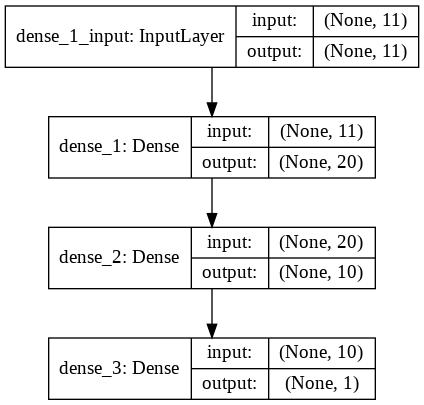

In [22]:
plot_model(classifier, show_shapes = True, show_layer_names = True)

**Predicting the Results**

In [23]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

**Making Confusion Matrix**

In [24]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[984,   5],
       [  3, 308]])

**Generating Accuracy & F1 Score**

In [25]:
F1_Score = f1_score(y_test, y_pred)
acs = accuracy_score(y_test, y_pred)
print('Accuracy = %s' % (acs),
      '\nF1 Score = %s' % (F1_Score))

Accuracy = 0.9938461538461538 
F1 Score = 0.9871794871794871
